In [1]:
# single-cell analysis package
library(Seurat)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

# load the Zhou et al snRNA-seq dataset
seurat_obj <- readRDS('Zhou_2020.rds')

Attaching SeuratObject

Attaching sp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




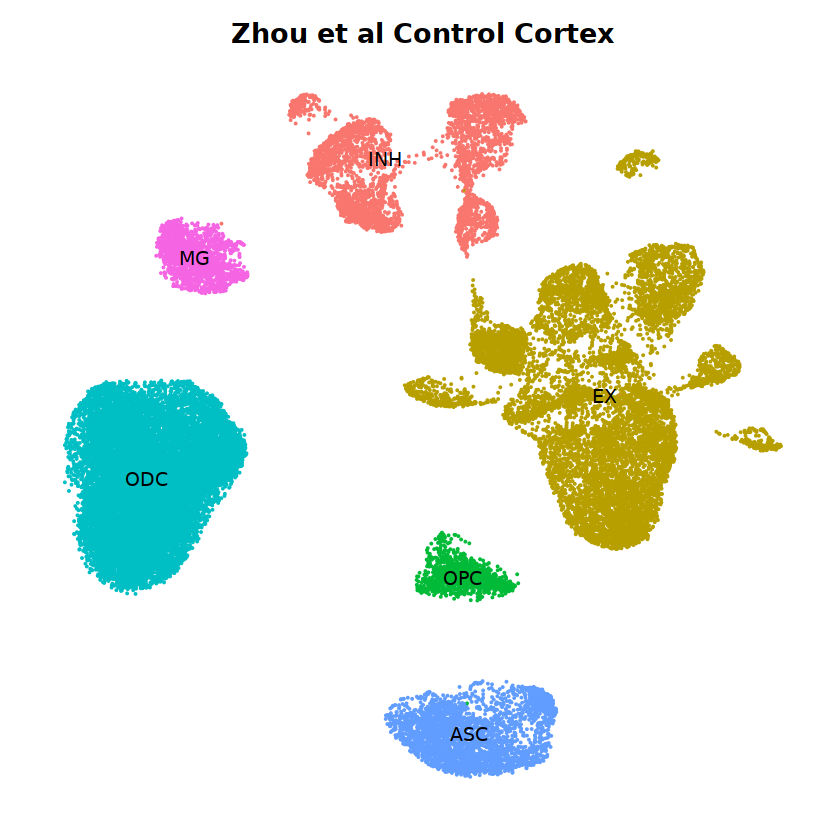

In [4]:
p <- DimPlot(seurat_obj, group.by='cell_type', label=TRUE) +
   umap_theme() + ggtitle('Zhou et al Control Cortex') + NoLegend()
p

# Set up Seurat object for WGCNA

In [6]:
seurat_obj <- SetupForWGCNA(
  seurat_obj,
  gene_select = "fraction", # the gene selection approach
  fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
  wgcna_name = "tutorial" # the name of the hdWGCNA experiment
)

In [11]:
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)

In [13]:
all.genes <- rownames(seurat_obj)
seurat_obj <- ScaleData(seurat_obj, features = all.genes)

Centering and scaling data matrix



In [16]:
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj))

PC_ 1 
Positive:  NEAT1, SLC5A11, GLUL, AC008571.2, AL033523.1, SLC1A3, LINC01170, AC012494.1, LURAP1L-AS1, SPP1 
	   ITPKB, FTH1, ERBB4, PLPP3, HIST1H2AC, FTL, ACSS1, LINC02073, BCL6, PARD3B 
	   MAML2, PREX2, ADAMTS18, PDLIM5, ZFP36, LINC02649, LRIG1, B2M, ARHGAP24, MT2A 
Negative:  DLGAP2, STXBP5L, CCSER1, MEG3, GRM5, KCNQ5, FRMPD4, RALYL, FGF12, LRFN5 
	   KALRN, ATRNL1, DCLK1, GABRB3, GABBR2, RGS7, KHDRBS2, KCNIP4, CACNA1B, CDH18 
	   GRIN2B, CACNA1C, NELL2, HECW1, GALNT17, LDB2, SYN2, SH3GL2, SNTG1, LRRTM4 
PC_ 2 
Positive:  PDE1A, SLC5A11, AC008571.2, AL033523.1, AC012494.1, LURAP1L-AS1, LINC01170, PWRN1, LAMA2, ROBO1 
	   SEMA3C, LINC02073, STMN1, IQCJ-SCHIP1, SPP1, GRID2, RYR2, ADAMTS18, SPANXA2-OT1, PRKCB 
	   VSTM2B, RTN1, KCNK1, SV2B, MAP1B, WASF1, LINC01098, LINC01122, LINC01505, ATP1A1 
Negative:  SLC1A2, ADGRV1, BMPR1B, GFAP, ATP1A2, PITPNC1, RYR3, STON2, F3, PARD3 
	   LINC00299, EFEMP1, ATP1B2, GJA1, FAM189A2, PLSCR4, SLC4A4, ALDH1L1, RGS20, CST3 
	   OBI1-AS1, GLIS3, 

In [17]:
# construct metacells  in each group
seurat_obj <- MetacellsByGroups(
  seurat_obj = seurat_obj,
  group.by = c("cell_type", "Sample"), # specify the columns in seurat_obj@meta.data to group by
  k = 25, # nearest-neighbors parameter
  max_shared = 10, # maximum number of shared cells between two metacells
  ident.group = 'cell_type' # set the Idents of the metacell seurat object
)

# normalize metacell expression matrix:
seurat_obj <- NormalizeMetacells(seurat_obj)

Warning message in MetacellsByGroups(seurat_obj = seurat_obj, group.by = c("cell_type", :
“Removing the following groups that did not meet min_cells: ASC#C4, MG#C2, MG#C3, MG#C4, ODC#C4, OPC#C12, OPC#C4, OPC#C9”


[1] "done making metacells"
[1] 58
[1] "metacell shape"


# Co-expression network analysis

## Select the data you want to run on

In [18]:
seurat_obj <- SetDatExpr(
  seurat_obj,
  group_name = "INH", # the name of the group of interest in the group.by column
  group.by='cell_type' # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
)

Warning message in SetDatExpr(seurat_obj, group_name = "INH", group.by = "cell_type"):
“assay not specified, trying to use assay RNA”


## Select soft-power threshold

pickSoftThreshold: will use block size 3539.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3539 of 12639


Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 3540 through 7078 of 12639


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 7079 through 10617 of 12639


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 10618 through 12639 of 12639


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   Power SFT.R.sq slope truncated.R.sq  mean.k. median.k.  max.k.
1      1   0.2890 12.10          0.943 6.53e+03  6.53e+03 7190.00
2      2   0.0306  1.87          0.989 3.44e+03  3.43e+03 4250.00
3      3   0.0209 -1.03          0.994 1.84e+03  1.82e+03 2600.00
4      4   0.1850 -2.44          0.973 1.00e+03  9.83e+02 1650.00
5      5   0.4630 -3.46          0.971 5.56e+02  5.37e+02 1090.00
6      6   0.6740 -4.04          0.978 3.14e+02  2.98e+02  741.00
7      7   0.7810 -4.09          0.985 1.80e+02  1.67e+02  519.00
8      8   0.8240 -4.09          0.990 1.05e+02  9.47e+01  372.00
9      9   0.8670 -3.91          0.992 6.25e+01  5.44e+01  273.00
10    10   0.8760 -3.80          0.995 3.78e+01  3.15e+01  204.00
11    12   0.8990 -3.41          0.996 1.46e+01  1.10e+01  119.00
12    14   0.8900 -3.14          0.983 6.11e+00  3.96e+00   73.60
13    16   0.8890 -2.83          0.979 2.76e+00  1.48e+00   47.40
14    18   0.8910 -2.55          0.978 1.34e+00  5.70e-01   31.60
15    20  

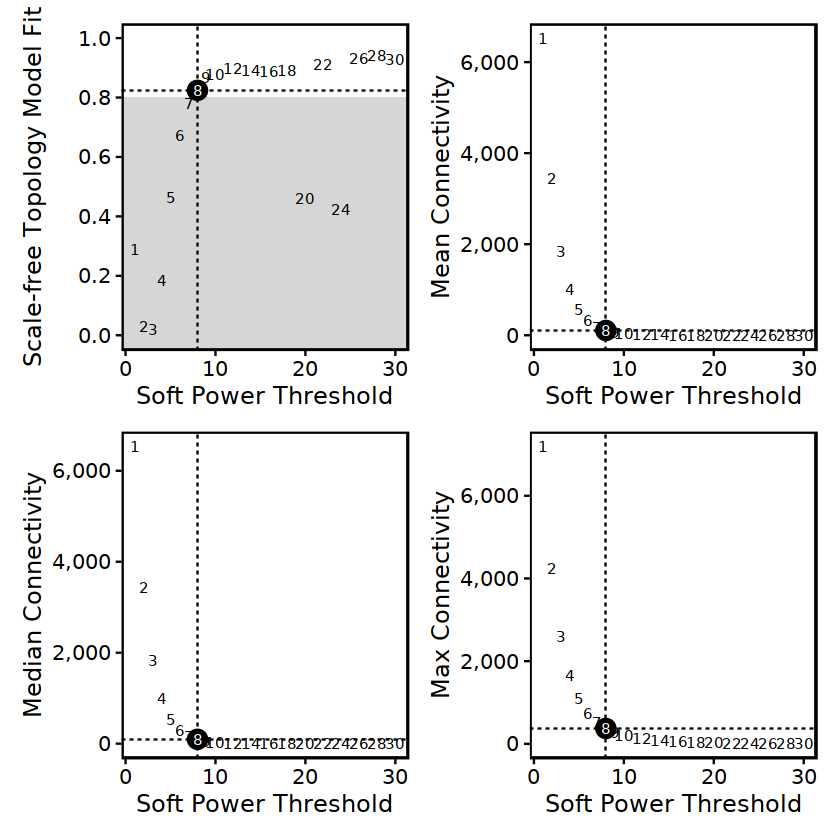

In [19]:
# Test different soft powers:
seurat_obj <- TestSoftPowers(
  seurat_obj,
  setDatExpr = FALSE, # set this to FALSE since we did this above
)

# plot the results:
plot_list <- PlotSoftPowers(seurat_obj)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

In [20]:
power_table <- GetPowerTable(seurat_obj)
head(power_table)

,Power,SFT.R.sq,slope,truncated.R.sq,mean.k.,median.k.,max.k.
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.28888950,12.083388,0.9432938,6528.0296,6534.7464,7192.0682
2,2,0.03062931,1.869772,0.9893246,3435.7192,3428.3365,4252.7339
3,3,0.02086653,-1.032898,0.9935139,1840.7641,1824.2350,2602.7579
4,4,0.18450032,-2.443615,0.9734010,1003.4722,983.3532,1646.5421
5,5,0.46336599,-3.460959,0.9705839,556.4642,537.3696,1087.6928
6,6,0.67355364,-4.039415,0.9783720,313.8895,297.7591,740.8639


## Construct co-expression network

In [21]:
# construct co-expression network:
seurat_obj <- ConstructNetwork(
  seurat_obj, soft_power=9,
  setDatExpr=FALSE,
  tom_name = 'INH' # name of the topoligical overlap matrix written to disk
)

 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


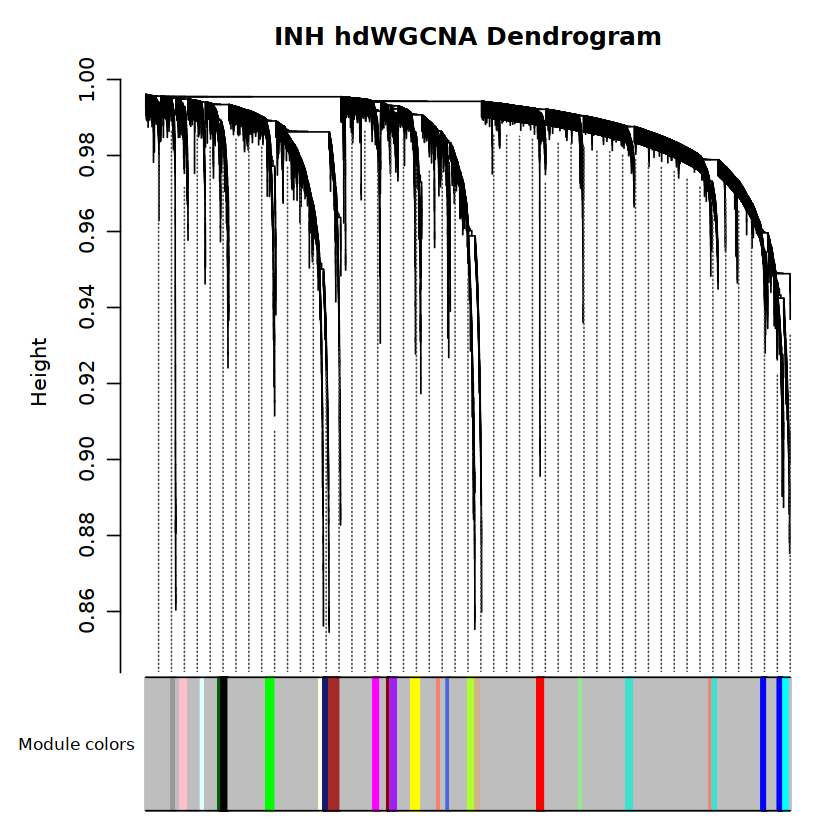

In [22]:
PlotDendrogram(seurat_obj, main='INH hdWGCNA Dendrogram')

## Module Eigengenes and Connectivity

In [23]:
# need to run ScaleData first or else harmony throws an error:
seurat_obj <- ScaleData(seurat_obj, features=VariableFeatures(seurat_obj))

# compute all MEs in the full single-cell dataset
seurat_obj <- ModuleEigengenes(
 seurat_obj,
 group.by.vars="Sample"
)

Centering and scaling data matrix



[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_”
pcagrey_ 1 
Positive:  PIP4K2A, ST18, TMEM144, TF, ENPP2, NCKAP5, PTGDS, CLMN, PHLPP1, TMEM165 
	   ERBIN, AL359091.1, MOG, CLDN11, COL4A5, CREB5, CERCAM, BCAS1, PXK, MOBP 
	   KCNH8, FAM107B, PDE8A, SLC7A14-AS1, ABCA8, LINC01608, SIK3, ELMO1, SLAIN1, ABCA2 
Negative:  PLCB1, CSMD1, OPCML, CELF2, FRMPD4, CACNA1C, KCNQ5, PTPRN2, CNKSR2, KCNMA1 
	   GRIN2B, CDH18, SCN8A, MRTFB, KCNIP4, PAK3, DNM1, EFNA5, SNTG1, LRRTM4 
	   MIR124-2HG, GABRG2, KCNJ3, KIAA1549L, SPTAN1, CACNA1A, SYT16, OXR1, FAM153CP, SPTBN4 
pcagrey_ 2 
Positive:  PTPRD, TTLL7, PEX5L, ANKS1B, ATP8A1, FRMD5, NKAIN2, NLGN1, DNAJC6, APLP1 
	   PTPRK, CNTNAP2, PPP1R16B, DLG1, ELMO1, SYNJ2, MYO1D, PPM1H, APBB2, ST18 
	   PRKACB, GNAI1

[1] "black"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablack to pcablack_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablack_”
pcablack_ 1 
Positive:  GSN, CTNNA3, RNF130, DST, WASF2, CCDC88A, MIRLET7BHG, COMMD10, AC007221.1, IL3RA 
	   NOL8, A2M, AC099489.1, BPTF, EFCAB13, AC097376.3, INSR, AC092650.1, LINC02742, KIF27 
	   PRPF4B, AL683813.1, CLIP2, PIAS4, IPCEF1, SON, ZBED4, ADGRG2, NPIPB15, ETFA 
Negative:  STXBP5L, CACNA1B, ANKRD30BL, GRIN1, BMS1P14, SNAP91, CHD5, AC068587.4, VPS13A, AC019211.1 
	   SIMC1, LINC01278, LINC00632, LHFPL4, AC092683.2, AP001266.2, ANKRD26, SPIDR, LINC01410, AL117190.2 
	   AC108519.1, AC139795.2, TTC3, GLCCI1, LINC01284, AC016723.1, AJ009632.2, DOCK3, IRAK1BP1, MRPL41 
pcablack_ 2 
Positive:  CTNNA3, DST, RNF130, CCDC88A, GSN, BPTF, DOCK3, MICAL3, IL3RA, EFCAB13 
	   SCAPER, CCDC14

[1] "green"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreen to pcagreen_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagreen_”
pcagreen_ 1 
Positive:  RIMS2, MYT1L, THRB, CACNA2D3, CHRM3, SCN2A, CNTN1, KCNB1, ROBO2, RGS6 
	   CACNA1E, MIR137HG, KCNB2, FAT3, GPM6A, FRMD4A, CACNB2, GRM1, BASP1, NELL1 
	   CDH10, NBEA, CNTN3, CBLN2, RUNDC3B, SCN3B, WASF1, CPNE4, GABRA2, TRHDE 
Negative:  PDE4B, VRK2, PDE1C, PALM2-AKAP2, DPYD, SPATA13, IQGAP1, JAM3, NPAS3, AGAP1 
	   NEO1, MARCH1, EVA1C, PLPPR1, SYT9, MIR100HG, L3MBTL4, SECISBP2L, PRMT2, GNAO1 
	   CFLAR, TLL2, NIPAL3, ANKRD28, AUTS2, AC018730.1, ABTB2, CTTNBP2, PWRN1, ARFGEF3 
pcagreen_ 2 
Positive:  NRXN3, DLG2, MARCH1, PALM2-AKAP2, AGAP1, PDE1C, DPYD, DMD, ARFGEF3, PDE1A 
	   JAM3, NALCN, AUTS2, ROBO1, ANKRD36, CADM2, SECISBP2L, GPR137C, IQGAP1, PDE4B 
	   PWRN1, GR

[1] "grey60"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey60 to pcagrey60_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey60_”
pcagrey60_ 1 
Positive:  KMT2C, CCDC200, USP47, MYO9B, BTBD7, BCAR1, PHF21B, SVIP, ARL8A, MIB1 
	   ABHD17A, SAMD1, NOL4L, FAM182A, HCN2, JMJD6, AL118511.1, MTSS2, BNIP3L, ZNF358 
	   CRK, OSBP2, DVL1, STK40, MAP2K3, NECTIN1, CSNK1E, RFX3, MAP2K2, GNB1 
Negative:  MT-CO3, MT-ND1, MT-CYB, MT-CO1, MT-ATP6, MT-CO2, MT-ND4L, MT-ND4, MT-ND5, MT-ND3 
	   MTRNR2L12, DHFR, MT-ND2, LINC01320, MTRNR2L1, MTRNR2L8, MT-ATP8, CAMK2B, MT-ND6, NCDN 
	   NPTX1, CELF5, NCS1, DLG4, MTRNR2L6, FBXL16, SYNPO, GALNT9, ADGRB1, ABR 
pcagrey60_ 2 
Positive:  

[1] "red"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcared to pcared_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcared_”
pcared_ 1 
Positive:  AIF1L, SGK3, OCLN, CLASP2, NASP, AC109927.1, S100PBP, ENTPD1-AS1, AC053527.2, TMEM256 
	   AC104596.1, MRPL48, THNSL2, C5, SLC13A3, MDM4, ADORA1, CCDC18-AS1, HSD17B7, TAGLN 
	   COA6-AS1, AC138627.1, ZNF208, WDFY3, SPG11, ZNF337-AS1, GTPBP6, L3MBTL1, LIFR-AS1, NOMO2 
Negative:  LINC00599, TARBP1, ABCC8, MAP3K21, USP9Y, TTTY14, TMEM145, ITGA3, TMEM179, HECTD4 
	   AL357153.2, NPIPA1, SYCE1, CDK10, ALG1L9P, ATAD2, SLC26A8, ECE2, NLGN4Y, ASB3 
	   PCDH11Y, MDN1, AKAP8L, NPHP1, AC092574.2, TNNT2, CC2D1A, KDM5D, HACL1, AC013460.1 
pcared_ 2 
Positive:  LINC00599, MAP3K21, ITGA3, ABCC8, FAM149A, TNNT2, TMEM145, SYCE1, TMEM179, SLC26A8 
	   ECE2, ATAD2, TARBP1, TNK2, CDK10, HECTD4,

[1] "lightcyan"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcalightcyan to pcalightcyan_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcalightcyan_”
pcalightcyan_ 1 
Positive:  AL157944.1, CELF2-DT, RREB1, ADPRHL1, MFSD10, ERCC6, SP140, DCLRE1A, FRS3, GMNN 
	   INO80C, SLC35E2A, OGG1, BCCIP, PCGF3, AC105411.1, C18orf21, SMARCD1, TAF5, SAYSD1 
	   RRAGC, ARL17A, PAPPA2, ZNF287, NBDY, RAB10, ZSCAN9, ZNF891, FN1, BLOC1S5 
Negative:  PLP1, RNF220, DOCK5, SLC44A1, UGT8, SLCO1A2, SHROOM4, CNDP1, FA2H, QDPR 
	   MAG, CDH19, LINC00320, DBNDD2, DOCK1, GPR37, PLLP, TMEM63A, CD9, AC110285.1 
	   TSC22D4, APOD, AL133304.3, MYRF, GATM, AC098679.5, CYP2J2, KLK6, UACA, CPM 
pcalightcya

[1] "tan"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcatan to pcatan_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcatan_”
pcatan_ 1 
Positive:  PLCL1, HHATL, SLC9A9, PTPN13, CDK6, ROR1, TAFA4, TBC1D5, LINC00894, RHOBTB3 
	   GLI3, PCCA-DT, AFF1, TMEM131L, UBE2E2, MEF2A, TEAD1, RNF144B, CEMIP, MIR34AHG 
	   PLCH2, CPED1, CNTNAP3C, CAPS2, TMEM132C, RUNX2, EAF2, MYO5B, ANKS1A, GALNT1 
Negative:  FGF12, DLGAP2, ATRNL1, KHDRBS2, HCN1, MDGA2, TAFA2, KCNC2, KCND2, LDB2 
	   SETBP1, DPP10, NAV3, SH3GL2, MEF2C, ATP2B2, ERC2, RASAL2, TMEM108, ADCY1 
	   LRRFIP1, EPHA6, NDST3, WIPF3, FAM78B, CUX2, LPCAT4, MROH1, ADARB1, MPP7 
pcatan_ 2 
Positive:  LDB2, SH3GL2, KHDRBS2, CUX2, DLGAP2, NDST3, ATRNL1, MPP7, PPFIA2, PLCL1 
	   ERC2, MDGA2, ADCY1, DRP2, FGF12, HCN1, TAFA2, HS3ST2, AC005906.2, WIPF3 
	   LPCAT4, ATP2B2, AC120193.1, 

[1] "royalblue"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaroyalblue to pcaroyalblue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaroyalblue_”
pcaroyalblue_ 1 
Positive:  GRM5, SYT1, SYN2, UNC5D, RAPGEF4, KCTD16, GRIP1, ATP8A2, MCTP1, PTPRT 
	   CAMK1D, PKNOX2, PAK5, AC073050.1, TENM4, SLC35F1, LIN7A, PTCHD4, FGF13, TRERF1 
	   MPPED1, BRINP2, TTC39B, DPP6, TOX, GRIA4, PLCXD3, MYO16, BCL11B, VWC2 
Negative:  TCF12, SGK1, UNC5C, IL1RAPL1, KIAA1324L, GRID1, DSCAML1, PKP4, ZNF462, TRPS1 
	   RASSF8, HECW2, TSPAN5, RAB3IP, ZNF827, GOLIM4, PTPRM, ANO6, VAV3, TOX3 
	   TTBK2, ARID5B, NECTIN3, BTBD9, COL4A1, MAMLD1, ALK, COL4A2, TOX2, SIPA1L1 
pcaroyalblue_ 2 
Positive:  

[1] "brown"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcabrown_”
pcabrown_ 1 
Positive:  QKI, FBXL7, CLIC4, SCD, NDRG1, FMNL2, SLCO3A1, SLC39A11, NFIA, TXNIP 
	   DOCK9, OLMALINC, DAPK2, FOXO1, CA2, SH3GL3, PLPP3, UNC5B, ACSS1, CYBRD1 
	   PHYHIPL, LTBP1, AKAP6, PBX3, EEPD1, MEIS2, POLK, ANK3, SFRP1, ATP11C 
Negative:  CCSER1, FGF14, MTUS2, GABBR2, AFF3, RBFOX3, CSMD3, RIMS1, GRIN2A, TMEM132D 
	   MSRA, SYN3, CABP1, CDK14, PHACTR1, FLRT2, NR2F1-AS1, MACROD2, KCNQ3, GRIA2 
	   KCND3, UNC13A, SLC2A13, PRKCB, PTPRO, PLXNA2, UNC13C, DGCR9, DAB1, POU6F2 
pcabrown_ 2 
Positive:  ANK3, SH3GL3, AKAP6, GAS7, SLCO3A1, SAMD12, DOCK9, PPFIBP1, CACNA2D1, GRIN2A 
	   PRKCB, GABBR2, SCD, CABP1, LRRC7, ATXN1, RBFOX3, SYNDIG1, DAPK2, ADAM22 
	   USP31, MTUS2, AFF3, SPANX

[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaturquoise_”
pcaturquoise_ 1 
Positive:  MEG3, AC024901.1, FAM27C, LINC02398, AEBP2, SLC25A12, NPM2, SRGAP3, TTC8, CORO6 
	   SLC35A1, RIC3, PPIP5K1, MYEF2, GOLT1B, ARMC2, AL391807.1, DPH1, ZNF248, ZFAND1 
	   OTUD3, HMGN3, CSNKA2IP, LUC7L, ZNF540, SRSF11, NIPSNAP3B, GPR155, YTHDC2, PIGZ 
Negative:  AC131944.1, MYO6, LINC02340, CIRBP, WSB1, NUDT12, PPP1R21, THAP6, ADHFE1, BCL2L2 
	   D2HGDH, FKBP15, UFL1, QRSL1, C1orf174, SRD5A3, SRP54, DDX17, RWDD3, CTNNA1 
	   TMEM50B, XPNPEP3, CLDND2, IFNGR1, PAAF1, TRMT10B, ERMARD, ICE2, ILKAP, ERI2 
pcaturquoise_ 2 
Positive:  MEG3, AC024901.1, NPM2, FAM27C, LINC02398, SLC25A12, PPIP5K1, AEBP2, SRGAP3, GPR155 
	   SERGEF, TTC8, PIGZ, ARMC2, NIPSNAP3B, S

[1] "lightyellow"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcalightyellow to pcalightyellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcalightyellow_”
pcalightyellow_ 1 
Positive:  KALRN, NRXN1, RGS7, GABRB3, LINGO2, DGKB, PCSK2, SORCS1, NEDD4L, CCDC85A 
	   NRG1, MAGI3, AC007563.2, HTR1E, EPHA5, NGEF, AC092691.1, PRR16, FRY, RNF150 
	   NPAS2, TNFRSF25, KCTD1, ANKRD30B, LSAMP, CCK, C8orf34, SEMA5B, NR2F1, ZBTB46 
Negative:  DOCK10, ZBTB20, SOX2-OT, CDH20, BAZ2B, EPN2, COBL, CNTNAP4, MBOAT2, SLC25A48 
	   KIAA1958, AP1S2, PREX2, NFIB, PELI2, ZBTB16, MARCH3, NFIX, FOXN3, IGDCC3 
	   NECAB1, GNG12, POU2F1, FLNB, AF279873.3, ARHGEF26-AS1, PARD3, FEZ2, ADARB2, C14orf132 

[1] "lightgreen"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcalightgreen to pcalightgreen_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcalightgreen_”
pcalightgreen_ 1 
Positive:  MAP2, NRCAM, GPR158, BAIAP2, IGSF9B, BSN, SYN1, HSPH1, SGSM1, PFKP 
	   PLPPR5, EGR3, HECTD2, PTMS, VGF, NREP, EGR1, HOPX, CCDC6, RPS6KA3 
	   VCL, CNIH2, ARC, RAB15, MARCKS, TTYH3, NAB2, GPRIN1, PKIG, SPRED2 
Negative:  PCSK6, CRYAB, RYBP, PTK2, PSME4, ELOVL5, SPSB1, PCGF5, SLC6A8, HP1BP3 
	   PPP2R1B, ARPC5, GNG5, SIK2, FOS, MIDN, GABPB1, CAST, INTS6, HSPA1A 
	   HSPA1B, LRRC8C, XIAP, NUCKS1, CDKN1A, SPIN1, FNDC3A, RCAN2, UCHL3, JUND 
pcalightgreen_ 2 
Positive:  MAP2, BSN, NRCAM, SGSM1, TLL

[1] "yellow"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcayellow_”
pcayellow_ 1 
Positive:  RALYL, GRIK2, ADGRL2, TMEM178B, NETO1, CERS6, CELF4, SLC8A1, CHL1, PTPRR 
	   CTNNA2, DAPK1, PRICKLE1, CHN1, KIAA1211L, CACNG3, CDH9, BCL11A, KCNJ6, DGKI 
	   SMYD3, FZD3, SYT7, EPHB6, GAP43, NRSN1, AC009899.1, PPM1L, MGAT4C, RPH3A 
Negative:  FRMD4B, TMTC2, FUT8, RBPJ, ZSWIM6, SEMA6A, TMCC3, ENOX2, CDH12, PRKCQ 
	   CRYBG3, TLE4, APOLD1, ANKRD44, RAP1GDS1, TMEFF2, ZNF704, AGPAT4, SYNE3, BACH2 
	   FGF1, AC026341.1, ANXA4, GXYLT2, ADAM10, OSTF1, ZNF488, NTM, POLA1, KIZ 
pcayellow_ 2 
Positive:  KIAA1211L, TMEFF2, SYT7, RALYL, CDH12, PLEKHA1, AGPAT4, REPS2, GAP43, ATL1 
	   EPHB6, ASXL3, DGKI, CHN1, PKN2-AS1, ADGRL2, PRICKLE1, CACNG3, PHF24, STYK1 
	   FRMD4B, PTP

[1] "salmon"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcasalmon to pcasalmon_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcasalmon_”
pcasalmon_ 1 
Positive:  TRIM2, SEPTIN4, LANCL1, ZNF738, CLIP4, KCNAB1, SESTD1, LPXN, PRKAA1, ZNF684 
	   TVP23B, SLITRK2, ZNF493, AL158152.1, LTN1, SLC25A27, FAHD2B, NDUFS2, MIPEP, MTMR4 
	   IST1, CTSL, CCDC174, ERGIC2, RCOR3, SLC4A8, SDHB, NTPCR, ZMYM6, MRPS11 
Negative:  MIAT, PACSIN1, STMN2, PNMA3, ME3, KIFAP3, KCNA2, SLC38A1, CDKL5, CAMKK2 
	   CFAP69, DENND1B, NEIL1, GOT1, OGDHL, ACTR2, LRCH1, SLC29A1, TMEM151B, MAP1A 
	   LYNX1, NNT, BOLA3, ADCYAP1R1, HAPLN4, STEAP2-AS1, MRPS30, RNPS1, AL590807.1, ATAD1 
pcasalmon_ 2 
Positive:  TRIM2, CLIP4, SESTD1, LANCL1, SLC25A27, SEPTIN4, ZNF493, RCOR3, SLC4A8, FAHD2B 
	   NDUFS2, ZNF738, CD47, MYSM1, LTN1, MIPEP, ERGIC2, SUCLG1, MTMR4, PRKA

[1] "pink"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcapink to pcapink_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcapink_”
pcapink_ 1 
Positive:  GABRB2, TMEM132B, SHISA9, AMPH, RIMBP2, PPP3CA, CNTN5, SHANK2, PDZRN3, MPP6 
	   INPP4B, CAP2, DCLK2, PRICKLE2, DOK6, TNR, MED12L, PRKCE, KCNN2, ZNF804B 
	   GRK3, U91319.1, SGCZ, PIP5K1B, SH3RF3, LMO7, ADCY9, CDH22, FNBP1L, DOK5 
Negative:  MBP, ZNF536, MTUS1, GPRC5B, SPOCK1, FAM13C, AGTPBP1, MOB3B, SGMS1, PIK3C2B 
	   IGSF11, SERINC5, LIFR, RETREG1, WWOX, SGK2, SSH2, KIRREL3, AC012178.1, ADD3 
	   RHOBTB1, ABHD6, FCHSD2, EVI5L, DGKD, PDGFRL, KMT5C, TMEM9B-AS1, MTMR7, RMDN1 
pcapink_ 2 
Positive:  MSI2, PRRX1, PRKCA, SLC7A2, HPSE2, TAB2, DCLK2, ADD3-AS1, MED12L, ETV1 
	   LIFR, AC002069.2, ZBTB7C, ST3GAL1, SEC14L1, ABCD2, SORL1, SNCAIP, HRH1, UFL1-AS1 
	   CEBPB, DENND1

[1] "magenta"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcamagenta to pcamagenta_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcamagenta_”
pcamagenta_ 1 
Positive:  NRG3, DCLK1, HECW1, ASIC2, CNTN4, NTRK3, HS6ST3, SRRM4, NMNAT2, PLXNA4 
	   NOL4, PPFIA4, DZIP1, NEK10, GABRA1, SLIT1, LINC01414, ZFPM2, CFAP221, COL26A1 
	   ZNF804A, RARB, TSPOAP1, FAM13A, DLGAP4, LRRC4C, SGPP2, RTN4RL1, CSGALNACT1, SPATS2 
Negative:  PLD1, NEAT1, EDIL3, MAP7, DYSF, SLC25A13, ANO4, TFEB, SNX29, GNG7 
	   AP000282.1, KLF3, RNF141, AMPD3, CYP7B1, TNS1, ERBB4, PPP1R12B, OTUD7A, BARD1 
	   YES1, PCBP4, PPARA, NOX4, PI4K2B, TTLL9, LPP, MBNL1, FGD4, AUH 
pcamagenta_ 2 
Positive:  PTPRZ1, ALDH1L1, ITPR2, LPP, CSGALNACT1, MCC, ZNF516, RAMP1, FGD4, NEAT1 
	   PLCE1, ERBB4, BCAR3, ADAMTS17, DNAH7, USP6NL, LYPD6, HFM1, NTRK3, SH2D4A 
	   COL27A1, PGM1

[1] "purple"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcapurple to pcapurple_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcapurple_”
pcapurple_ 1 
Positive:  KLHL32, LINC02241, LRRC8D, AL139383.1, CPQ, ZNF280D, RFX3-AS1, PRTFDC1, ZNF621, AF165147.1 
	   AL162253.2, ZCWPW1, ENO4, SLC38A9, TPCN1, FPGT, ZC3H6, MTAP, SPATA5, ZNF438 
	   AZIN1-AS1, ZGRF1, RIC1, TAB1, CATSPERE, RSRC1, FANCC, ZFP14, INVS, TCF7L2 
Negative:  UNC80, FAM153B, MAP4K3-DT, STAT4, FAM153A, MEF2C-AS1, AL136317.2, KIAA0825, NME5, SVOP 
	   TRMT11, AL445433.2, SULT1A1, FAM85B, AC079781.5, LINC02245, AC005753.2, LRRC28, AC104806.2, FTX 
	   EIF4E1B, RFLNA, DNAAF4, CDC40, DYNC2LI1, TTC21A, NAALAD2, TCTN2, METTL24, ARAP3 
pcapurple_ 2 
Positive:  LINC02241, KLHL32, ZNF280D, LRRC8D, AF165147.1, CPQ, KANSL1, RFX3-AS1, INVS, FTX 
	   ZC3H6, PRTFDC1, AL13938

[1] "cyan"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcacyan to pcacyan_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcacyan_”
pcacyan_ 1 
Positive:  H3F3B, PTMA, FTL, CD63, C4orf48, PFN1, FTH1, SERF2, POLR2I, ATP5F1E 
	   PPDPF, C12orf57, RPL38, PSMB6, WDR83OS, RPL35, HSPE1, MICOS13, C19orf53, PRDX1 
	   RPS13, TRMT112, UBA52, UBL5, NDUFB11, APP, FAU, RPL36, RPLP2, TPT1 
Negative:  SNAP25, CALM1, HSP90AB1, GAPDH, ATP6V0C, RAB3A, UCHL1, SNCB, PCSK1N, CALM3 
	   YWHAG, YWHAH, ARL6IP1, VAMP2, PEBP1, TPI1, YWHAB, NGRN, IDS, HSPA8 
	   PRNP, BEX1, BEX3, PPIA, STMN1, SEZ6L2, ARF3, OAZ1, TSPYL4, PNMA2 
pcacyan_ 2 
Positive:  FTL, FTH1, PTMA, RPLP1, ATP5F1E, H3F3B, EEF1A1, PFN1, RPL41, RPL35 
	   RPL28, RPS15, FAU, SERF2, ACTB, TPT1, RPS13, CD63, RPL38, UBA52 
	   UBC, PRDX1, RPLP2, TMSB4X, C4orf48, RPL36, HSP90AA1, EIF1, RP

[1] "greenyellow"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreenyellow to pcagreenyellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagreenyellow_”
pcagreenyellow_ 1 
Positive:  DLGAP1, FAM155A, RBFOX1, AGBL4, SLC4A10, CADPS, LRFN5, TENM2, PCLO, CACNB4 
	   ZNF385B, NEGR1, XKR4, SORBS2, OSBPL6, ST6GALNAC5, PAM, MMP16, RYR2, KIAA1217 
	   SYBU, AC090578.1, GRIA3, MICAL2, TMEM178A, STXBP5-AS1, SATB1-AS1, MAPK10, ANKRD34C-AS1, ELAVL2 
Negative:  PIEZO2, MIR181A1HG, SPOCK3, PPP2R2B, SLC24A2, AOPEP, TANC1, NFASC, ST6GALNAC3, FHIT 
	   SASH1, MITF, RAPGEF6, LIMCH1, RAPGEF5, STARD9, GAREM1, SFMBT2, PKD2, AC079921.1 
	   MAGI2, DIPK2A, STXBP6, ENOX1, AC104123.1, AKNA, AL158077.2, TTLL11, NF1, ZNF124 
pcagreenyellow_ 2 
Positive:  DTNA, SPARCL1, ETV6, RNASET2, AHCYL2, SFMBT2, PLOD2, PRKG1, ANTXR1, TRIO 
	   SOX6, MAPK10, ADCY8

[1] "midnightblue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcamidnightblue to pcamidnightblue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcamidnightblue_”
pcamidnightblue_ 1 
Positive:  DSCAM, NELL2, GALNT17, GRM7, OLFM3, ARPP21, LRFN2, NIPAL2, SEZ6L, KCNT2 
	   SORCS3, AC124852.1, UNC5A, ENC1, DIRC3, TRMT9B, NPY1R, TDRG1, CNR1, DNAH14 
	   LINC00923, NR3C2, PTH2R, TSHZ2, JCAD, AL024495.1, HPCA, COL11A1, STIM1, MAPK4 
Negative:  HIPK2, HIP1, KANK1, AC079352.1, ARHGAP21, CHD7, ZFHX4, CPNE2, FAM126A, SORT1 
	   KCNJ2, SVEP1, NCAM1, NAALADL2, AC087564.1, AC016821.1, PROX1, ELN, FAT4, DPF3 
	   SALL1, FIGN, SMOC1, B3GAT1, AFDN, PROX1-AS1, AC233296.1, JAK1, AK5, LCORL 
pcamidnightblue_ 2 
Positive:  HIF3A, RYR3, LRRC3B, AL589740.1, C3orf70, AC114971.1, MAPK4, MIR99AHG, PDE3A, EMID1 
	   FIGN, COL21A1, RXRA, KANK1, ZFHX4, COL11

[1] "blue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablue_”
pcablue_ 1 
Positive:  MAT2A, GSTK1, JPX, RNF13, ZC3H11A, CNPY2, ARL2BP, PCBP2, TMEM167A, PDHB 
	   TMED7, TMEM246, DGUOK, TMEM59, CASD1, SDR39U1, KDELR2, SPCS2, B3GAT3, SLC39A7 
	   SHISA4, EBLN3P, ACP1, EIF2A, NDUFV1, API5, PTPMT1, PPIB, RAB1B, RCN2 
Negative:  ATP1A3, MDH1, THY1, TUBA1B, TMEM59L, TUBB2A, CHGA, ENO2, RTN1, PKM 
	   SERINC1, ALDOA, CHGB, CLSTN3, B4GAT1, NAP1L2, BSCL2, SYT4, NPTN, TUBA4A 
	   NORAD, ATP1A1, APLP2, SCG5, TOMM20, TUBB3, TUBB4B, MOAP1, SARAF, ATP5F1B 
pcablue_ 2 
Positive:  MAT2A, RNF13, TMEM59, JPX, NDUFV1, PCBP2, RTN4, GSTK1, PPIB, SYT11 
	   CNPY2, SHISA4, SDR39U1, RCN2, TMED7, SPCS2, OCIAD1, ZC3H11A, TUFM, CTSF 
	   CANX, PSAP, XRCC5, SPINT2, TMEM167A, HSPA5,

[1] "darkred"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcadarkred to pcadarkred_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcadarkred_”
pcadarkred_ 1 
Positive:  NUTM2A-AS1, FAM53B, CRADD, AC011346.1, LHPP, MYO18A, ANKMY1, BCAS3, JAKMIP3, GMDS-DT 
	   FAF1, TSGA10, RESF1, EFCAB2, EIF2B3, KIF16B, AC009061.2, SIPA1L3, METAP1D, LINC00476 
	   CENPJ, RPTOR, Z94721.1, CCDC138, ZCWPW2, SRRM2, RALGPS1, AC009120.2, LRRC37A3, CEP290 
Negative:  KSR2, SRRM3, SNHG14, LINC01250, DANT2, AC016745.1, RORA, FBXL17, BX664727.3, TNRC6A 
	   CCDC30, RAD9A, AC092745.5, AP006261.1, MPHOSPH9, FAM66D, AL592183.1, FARS2, AL158832.2, TOM1L1 
	   RABGAP1L, AC005670.3, LINC00662, TNRC6B, HC

[1] "darkgreen"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcadarkgreen to pcadarkgreen_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcadarkgreen_”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”
pcadarkgreen_ 1 
Pos

In [24]:
# harmonized module eigengenes:
hMEs <- GetMEs(seurat_obj)

# module eigengenes:
MEs <- GetMEs(seurat_obj, harmonized=FALSE)

## Compute module connectivity

In [25]:
# compute eigengene-based connectivity (kME):
seurat_obj <- ModuleConnectivity(
  seurat_obj,
  group.by = 'cell_type', group_name = 'INH'
)

Warning message in bicor(datExpr, datME, , use = "p"):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


In [26]:
# rename the modules
seurat_obj <- ResetModuleNames(
  seurat_obj,
  new_name = "INH-M"
)

[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "INH-M6"
[1] "INH-M7"
[1] "INH-M8"
[1] "INH-M9"
[1] "INH-M10"
[1] "INH-M11"
[1] "INH-M12"
[1] "INH-M13"
[1] "INH-M14"
[1] "INH-M15"
[1] "INH-M16"
[1] "INH-M17"
[1] "INH-M18"
[1] "INH-M19"
[1] "INH-M20"
[1] "INH-M21"
[1] "INH-M22"
[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "INH-M6"
[1] "INH-M7"
[1] "INH-M8"
[1] "INH-M9"
[1] "INH-M10"
[1] "INH-M11"
[1] "INH-M12"
[1] "INH-M13"
[1] "INH-M14"
[1] "INH-M15"
[1] "INH-M16"
[1] "INH-M17"
[1] "INH-M18"
[1] "INH-M19"
[1] "INH-M20"
[1] "INH-M21"
[1] "INH-M22"


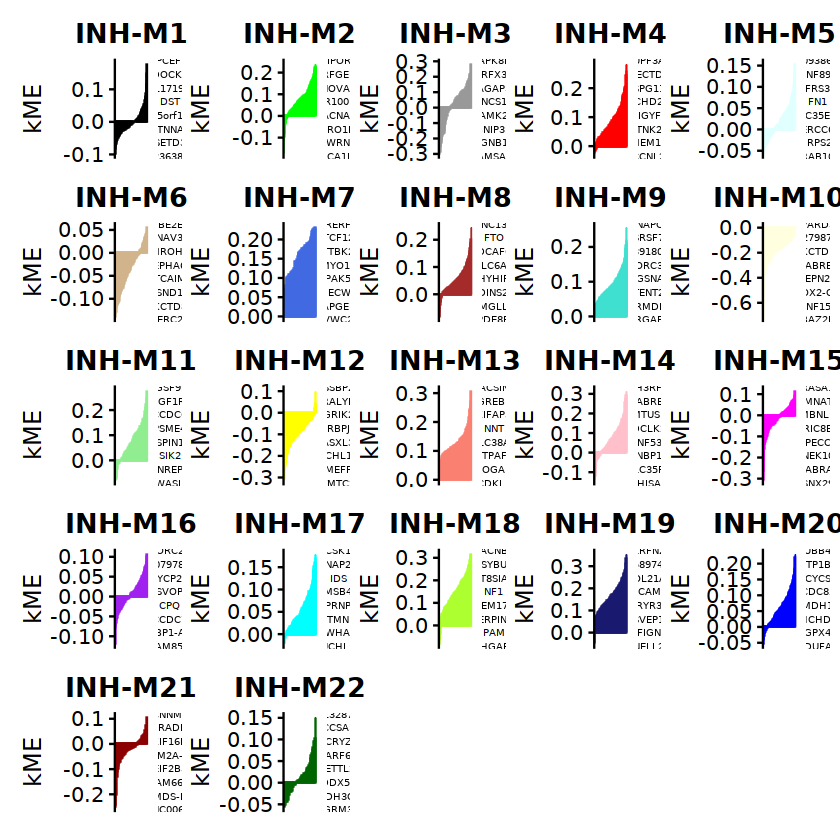

In [27]:
# plot genes ranked by kME for each module
p <- PlotKMEs(seurat_obj, ncol=5)
p

## Getting the module assignment table

In [28]:
# get the module assignment table:
modules <- GetModules(seurat_obj)

# show the first 6 columns:
head(modules[,1:6])

,gene_name,module,color,kME_grey,kME_INH-M1,kME_INH-M2
,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
AL627309.1,AL627309.1,grey,grey,-2.348794e-02,-0.041431912,0.06475936
LINC01409,LINC01409,INH-M1,black,8.832241e-03,-0.005445180,0.07100855
LINC01128,LINC01128,grey,grey,2.335052e-02,-0.045492473,0.10643815
NOC2L,NOC2L,grey,grey,2.239494e-02,-0.050635030,0.09762553
AGRN,AGRN,grey,grey,-8.881804e-05,0.012060664,0.06925256
C1orf159,C1orf159,grey,grey,-3.520602e-03,0.002986991,0.01490418


In [29]:
# get hub genes
hub_df <- GetHubGenes(seurat_obj, n_hubs = 10)

head(hub_df)

,gene_name,module,kME
,<chr>,<fct>,<dbl>
1,GSN,INH-M1,0.06771211
2,IPCEF1,INH-M1,0.07415352
3,DOCK3,INH-M1,0.07664834
4,AL117190.2,INH-M1,0.08043019
5,DST,INH-M1,0.08773661
6,C5orf17,INH-M1,0.09070067


In [30]:
saveRDS(seurat_obj, file='hdWGCNA_object.rds')

In [31]:
# compute gene scoring for the top 25 hub genes by kME for each module
# with Seurat method
seurat_obj <- ModuleExprScore(
  seurat_obj,
  n_genes = 25,
  method='Seurat'
)

Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
Selecting by kME_INH-M6
Selecting by kME_INH-M7
Selecting by kME_INH-M8
Selecting by kME_INH-M9
Selecting by kME_INH-M10
Selecting by kME_INH-M11
Selecting by kME_INH-M12
Selecting by kME_INH-M13
Selecting by kME_INH-M14
Selecting by kME_INH-M15
Selecting by kME_INH-M16
Selecting by kME_INH-M17
Selecting by kME_INH-M18
Selecting by kME_INH-M19
Selecting by kME_INH-M20
Selecting by kME_INH-M21
Selecting by kME_INH-M22


# Basic Visualization

## Module Feature Plots

[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "INH-M6"
[1] "INH-M7"
[1] "INH-M8"
[1] "INH-M9"
[1] "INH-M10"
[1] "INH-M11"
[1] "INH-M12"
[1] "INH-M13"
[1] "INH-M14"
[1] "INH-M15"
[1] "INH-M16"
[1] "INH-M17"
[1] "INH-M18"
[1] "INH-M19"
[1] "INH-M20"
[1] "INH-M21"
[1] "INH-M22"


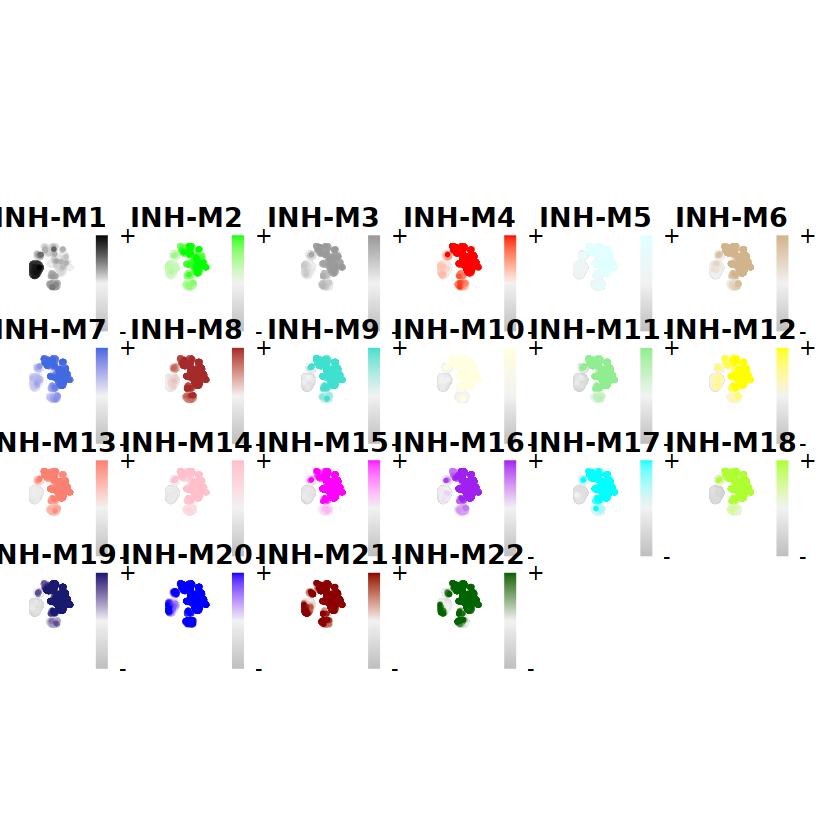

In [32]:
# make a featureplot of hMEs for each module
plot_list <- ModuleFeaturePlot(
  seurat_obj,
  features='hMEs', # plot the hMEs
  order=TRUE # order so the points with highest hMEs are on top
)

# stitch together with patchwork
wrap_plots(plot_list, ncol=6)

[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "INH-M6"
[1] "INH-M7"
[1] "INH-M8"
[1] "INH-M9"
[1] "INH-M10"
[1] "INH-M11"
[1] "INH-M12"
[1] "INH-M13"
[1] "INH-M14"
[1] "INH-M15"
[1] "INH-M16"
[1] "INH-M17"
[1] "INH-M18"
[1] "INH-M19"
[1] "INH-M20"
[1] "INH-M21"
[1] "INH-M22"


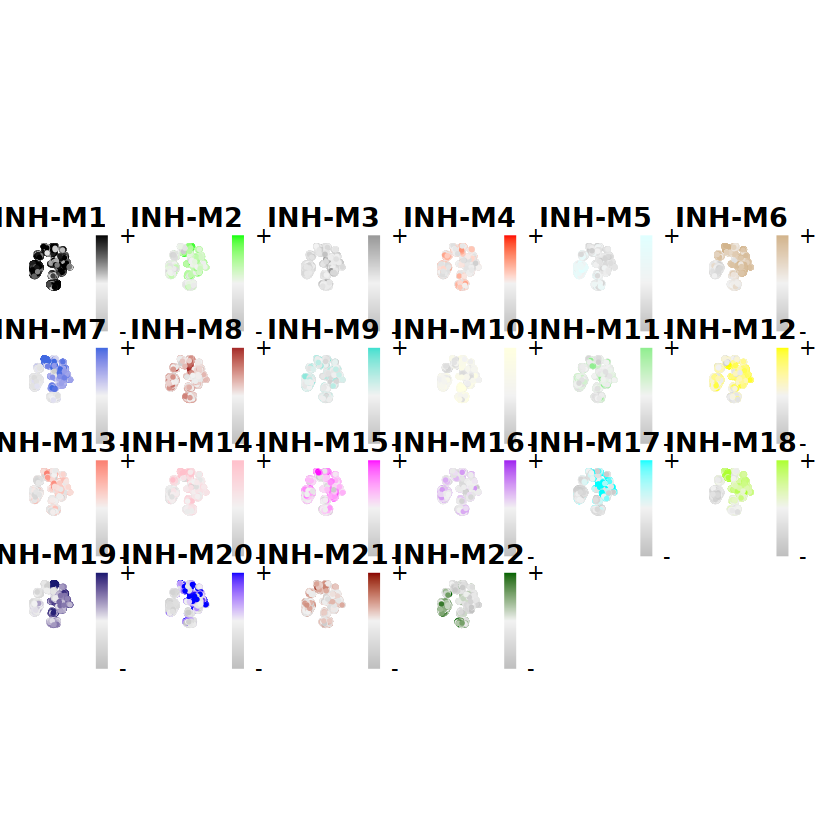

In [38]:
# make a featureplot of hub scores for each module
plot_list <- ModuleFeaturePlot(
  seurat_obj,
  features='scores', # plot the hub gene scores
  order='shuffle', # order so cells are shuffled
  ucell = FALSE # depending on Seurat vs UCell for gene scoring
)

# stitch together with patchwork
wrap_plots(plot_list, ncol=6)

## Module Correlations

Warning message in pNew > sig.level:
“longer object length is not a multiple of shorter object length”


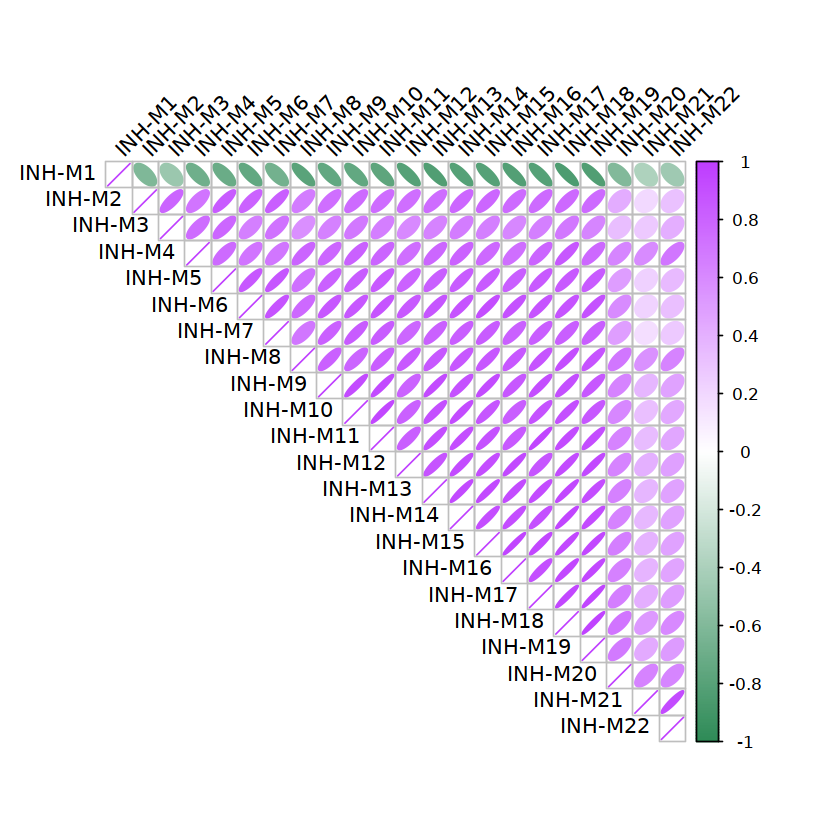

In [39]:
# plot module correlagram
ModuleCorrelogram(seurat_obj)

## Seurat plotting functions

In [40]:
# get hMEs from seurat object
MEs <- GetMEs(seurat_obj, harmonized=TRUE)
mods <- colnames(MEs); mods <- mods[mods != 'grey']

# add hMEs to Seurat meta-data:
seurat_obj@meta.data <- cbind(seurat_obj@meta.data, MEs)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



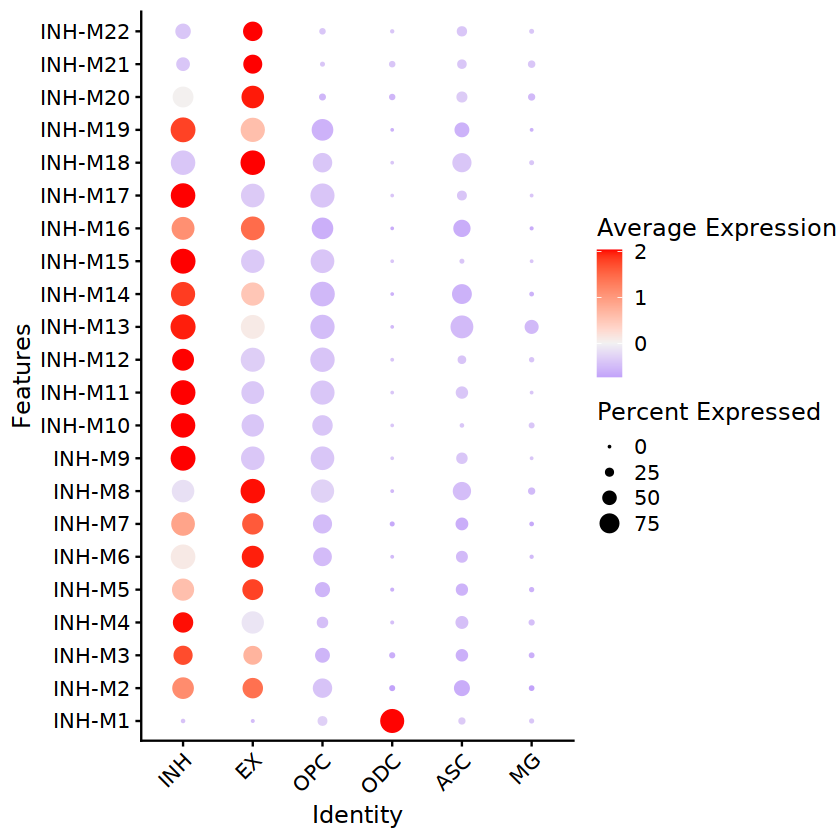

In [41]:
# plot with Seurat's DotPlot function
p <- DotPlot(seurat_obj, features=mods, group.by = 'cell_type')

# flip the x/y axes, rotate the axis labels, and change color scheme:
p <- p +
  coord_flip() +
  RotatedAxis() +
  scale_color_gradient2(high='red', mid='grey95', low='blue')

# plot output
p

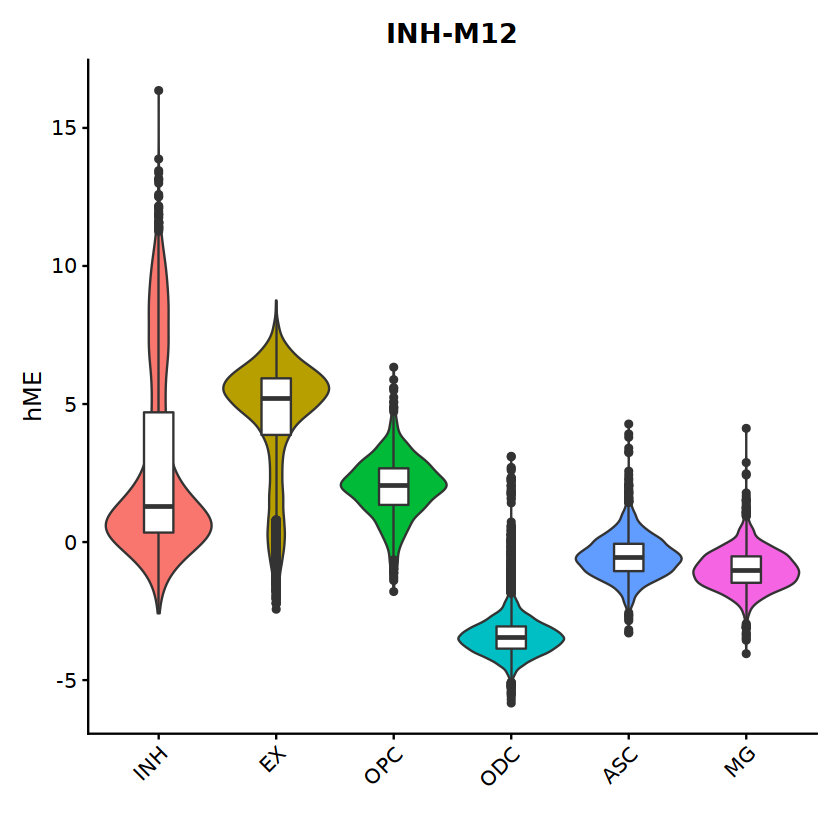

In [42]:
# Plot INH-M4 hME using Seurat VlnPlot function
p <- VlnPlot(
  seurat_obj,
  features = 'INH-M12',
  group.by = 'cell_type',
  pt.size = 0 # don't show actual data points
)

# add box-and-whisker plots on top:
p <- p + geom_boxplot(width=.25, fill='white')

# change axis labels and remove legend:
p <- p + xlab('') + ylab('hME') + NoLegend()

# plot output
p